# The Data

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.
https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=icml_face_data.csv

## Preprocessing in one step

In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

path = '../../../project_data/fer2013/icml_face_data.csv'
df = pd.read_csv(path)

# creating a dataframe that only contains training data
train = df[df[' Usage']=='Training'].copy()
# dropping the usage column
train.drop([' Usage'], axis = 1, inplace = True)


# creating the test dataframe, dropping the usage column and reseting the index
test = df[df[' Usage']=='PrivateTest'].copy()
test.drop([' Usage'], axis = 1, inplace = True)
test.reset_index(inplace = True, drop = True)

# creating the validation dataframe and dropping the usage column and reseting the index
validation = df[df[' Usage']=='PublicTest'].copy()
validation.drop([' Usage'], axis = 1, inplace = True)
validation.reset_index(inplace=True, drop = True)


def get_pixels_and_scale(data):
    '''
    Function for extracting pixel values from the pixel column and scaling them between 0 and 1
    
    get values from the column|
    split on the whitespace
    convert to float16 datatype
    save as as numpy array
    scale the values between 0 and 1
    '''
    
    img_array = np.array(data.split(' '), dtype = 'float16')
    img_array = img_array / 255.0
    
    return img_array

def reshape_images(data):
    '''
    reshape pixels column into desired format
    return a numpy array
    '''

    reshaped_array = np.reshape(data[' pixels'].to_list(),(data.shape[0],48,48,1))
    
    return reshaped_array

def plot_random_images(dataset): 
    if np.array_equal(dataset, train_images):
        labels = train_labels
    else:
        labels = test_labels

    # Checking 25 random images from the train set across all classes
    plt.figure(figsize=(12,12))
    for ind, img_num in enumerate(np.random.randint(1,len(dataset),size=25)):
        plt.subplot(5,5,ind+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(dataset[img_num], cmap='gray')
        plt.xlabel(emotions[labels[img_num]])
    plt.show()
    
def plot_model_accuracy(fitted_model):
    '''
    Function visualizing comparison of 
    training and validaton loss and accuracy
    
    '''
    
    fig , ax = plt.subplots(1,2)
    train_acc = fitted_model.history['accuracy']
    train_loss = fitted_model.history['loss']
    fig.set_size_inches(15,4)

    ax[0].plot(fitted_model.history['accuracy'])
    ax[0].plot(fitted_model.history['val_accuracy'])
    ax[0].set_title('Training vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='lower right')

    ax[1].plot(fitted_model.history['loss'])
    ax[1].plot(fitted_model.history['val_loss'])
    ax[1].set_title('Training vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Validation'], loc='lower left')

    plt.show()
    

# extracting pixel values from the pixel column and scaling them between 0 and 1    
train[' pixels'] = train[' pixels'].apply(get_pixels_and_scale)   
test[' pixels'] = test[' pixels'].apply(get_pixels_and_scale)
validation[' pixels'] = validation[' pixels'].apply(get_pixels_and_scale)

# reshaping pixels column into a desired format and getting a numpy array
train_images = reshape_images(train)
test_images = reshape_images(test)
validation_images = reshape_images(validation)


# getting the labels
train_labels = train['emotion']
test_labels = test['emotion']
validation_labels = validation['emotion']

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)
print(validation_images.shape, validation_labels.shape)

(28709, 48, 48, 1) (28709,)
(3589, 48, 48, 1) (3589,)
(3589, 48, 48, 1) (3589,)


In [39]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten

print(tf.__version__)

2.8.0


In [40]:
# one-hot encoding
y_train = tf.keras.utils.to_categorical(train_labels, 7)
y_test = tf.keras.utils.to_categorical(test_labels, 7)
y_validation = tf.keras.utils.to_categorical(validation_labels, 7)

In [ ]:
# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)

### Base Model - over 6 min per epoch without pooling!

In [75]:
# creating a sequential model
mdl1 = Sequential()
mdl1.add(
    Conv2D(
        128, kernel_size = 4, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)

mdl1.add(
    Conv2D(
        128, kernel_size = 4, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)

mdl1.add(
    Conv2D(
        256, kernel_size = 4, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)

mdl1.add(Flatten())
mdl1.add(Dense(7, activation='softmax'))

# compile the model
mdl1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

mdl1_performance = mdl1.fit(
    x=train_images,
    y=y_train, 
    validation_data = (validation_images, y_validation),
    epochs=10)

#compare how the model performs on the test dataset:
mdl1_test_loss, mdl1_test_acc = mdl1.evaluate(test_images, y_test, verbose=2)
print(f'\nTest accuracy: {mdl1_test_acc * 100.0:.2f}%')

# visualize accuracy
plot_model_accuracy(mdl1_performance)

Epoch 1/10
898/898 [==============================] - 405s 451ms/step - loss: 1.6822 - accuracy: 0.3423 - val_loss: 1.5756 - val_accuracy: 0.3982
Epoch 2/10
 31/898 [>.............................] - ETA: 6:19 - loss: 1.5085 - accuracy: 0.4183

KeyboardInterrupt: 

### MDL2: Base + Kernel Size = 3

In [61]:
# creating a sequential model
mdl2 = Sequential()
mdl2.add(
    Conv2D(
        128, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl2.add(MaxPool2D(2))

mdl2.add(
    Conv2D(
        128, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl2.add(MaxPool2D(2))

mdl2.add(
    Conv2D(
        256, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl2.add(MaxPool2D(2))


mdl2.add(Flatten())
mdl2.add(Dense(7, activation='softmax'))

# compile the model
mdl2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

mdl2_performance = mdl2.fit(
    x=train_images,
    y=y_train, 
    validation_data = (validation_images, y_validation),
    epochs=10)

#compare how the model performs on the test dataset:
mdl2_test_loss, mdl2_test_acc = mdl2.evaluate(test_images,  y_test, verbose=2)
print(f'\nTest accuracy: {mdl2_test_acc * 100.0:.2f}%')

plot_model_accuracy(mdl2_performance)

Epoch 1/10
898/898 [==============================] - 50s 56ms/step - loss: 1.6092 - accuracy: 0.3690 - val_loss: 1.4059 - val_accuracy: 0.4634
Epoch 2/10
898/898 [==============================] - 50s 56ms/step - loss: 1.3293 - accuracy: 0.4969 - val_loss: 1.2655 - val_accuracy: 0.5191
Epoch 3/10
898/898 [==============================] - 50s 56ms/step - loss: 1.1986 - accuracy: 0.5515 - val_loss: 1.2137 - val_accuracy: 0.5386
Epoch 4/10
898/898 [==============================] - 50s 56ms/step - loss: 1.1043 - accuracy: 0.5902 - val_loss: 1.2166 - val_accuracy: 0.5467
Epoch 5/10
898/898 [==============================] - 50s 56ms/step - loss: 1.0095 - accuracy: 0.6292 - val_loss: 1.2331 - val_accuracy: 0.5408
Epoch 6/10
898/898 [==============================] - 51s 57ms/step - loss: 0.9192 - accuracy: 0.6626 - val_loss: 1.2424 - val_accuracy: 0.5667
Epoch 7/10
898/898 [==============================] - 51s 57ms/step - loss: 0.8314 - accuracy: 0.6983 - val_loss: 1.2457 - val_accuracy:

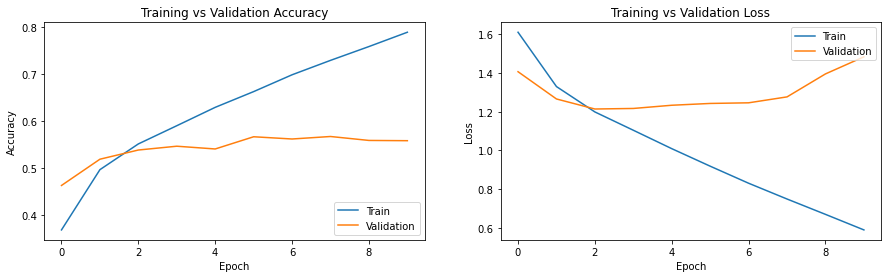

In [69]:
plot_model_accuracy(mdl2_performance)

### MDL3: Base + Kernel Size = 4

Epoch 1/10


/Users/ivan.miller/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


898/898 [==============================] - 71s 79ms/step - loss: 1.6384 - accuracy: 0.3526 - val_loss: 1.4775 - val_accuracy: 0.4274
Epoch 2/10
898/898 [==============================] - 71s 79ms/step - loss: 1.3672 - accuracy: 0.4810 - val_loss: 1.3491 - val_accuracy: 0.4851
Epoch 3/10
898/898 [==============================] - 71s 79ms/step - loss: 1.2282 - accuracy: 0.5359 - val_loss: 1.2363 - val_accuracy: 0.5361
Epoch 4/10
898/898 [==============================] - 71s 79ms/step - loss: 1.1214 - accuracy: 0.5826 - val_loss: 1.2406 - val_accuracy: 0.5405
Epoch 5/10
898/898 [==============================] - 72s 80ms/step - loss: 1.0241 - accuracy: 0.6220 - val_loss: 1.2400 - val_accuracy: 0.5450
Epoch 6/10
898/898 [==============================] - 75s 83ms/step - loss: 0.9300 - accuracy: 0.6584 - val_loss: 1.2581 - val_accuracy: 0.5520
Epoch 7/10
898/898 [==============================] - 75s 84ms/step - loss: 0.8346 - accuracy: 0.6986 - val_loss: 1.3007 - val_accuracy: 0.5341
Epo

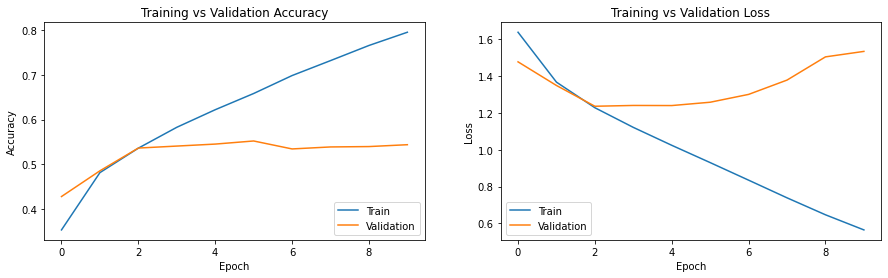

In [73]:
# creating a sequential model
mdl3 = Sequential()
mdl3.add(
    Conv2D(
        128, kernel_size = 4, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl3.add(MaxPool2D(2))

mdl3.add(
    Conv2D(
        128, kernel_size = 4, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl3.add(MaxPool2D(2))

mdl3.add(
    Conv2D(
        256, kernel_size = 4, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl3.add(MaxPool2D(2))


mdl3.add(Flatten())
mdl3.add(Dense(7, activation='softmax'))

# compile the model
mdl3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

mdl3_performance = mdl3.fit(
    x=train_images,
    y=y_train, 
    validation_data = (validation_images, y_validation),
    epochs=10)

#compare how the model performs on the test dataset:
mdl3_test_loss, mdl3_test_acc = mdl3.evaluate(test_images,  y_test, verbose=2)
print(f'\nTest accuracy: {mdl3_test_acc * 100.0:.2f}%')

# visualize accuracy
plot_model_accuracy(mdl3_performance)

### MDL4: Base + Kernel Size = 2

Epoch 1/10
898/898 [==============================] - 43s 47ms/step - loss: 1.6298 - accuracy: 0.3616 - val_loss: 1.4713 - val_accuracy: 0.4363
Epoch 2/10
898/898 [==============================] - 45s 50ms/step - loss: 1.3801 - accuracy: 0.4743 - val_loss: 1.3190 - val_accuracy: 0.4960
Epoch 3/10
898/898 [==============================] - 49s 55ms/step - loss: 1.2645 - accuracy: 0.5233 - val_loss: 1.2876 - val_accuracy: 0.5113
Epoch 4/10
898/898 [==============================] - 49s 55ms/step - loss: 1.1899 - accuracy: 0.5536 - val_loss: 1.2677 - val_accuracy: 0.5210
Epoch 5/10
898/898 [==============================] - 47s 53ms/step - loss: 1.1270 - accuracy: 0.5791 - val_loss: 1.2366 - val_accuracy: 0.5333
Epoch 6/10
898/898 [==============================] - 48s 53ms/step - loss: 1.0692 - accuracy: 0.6033 - val_loss: 1.2378 - val_accuracy: 0.5417
Epoch 7/10
898/898 [==============================] - 48s 54ms/step - loss: 1.0161 - accuracy: 0.6266 - val_loss: 1.2554 - val_accuracy:

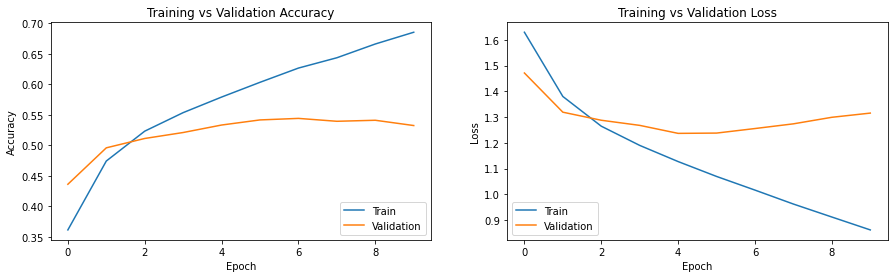

In [74]:
# creating a sequential model
mdl4 = Sequential()
mdl4.add(
    Conv2D(
        128, kernel_size = 2, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl4.add(MaxPool2D(2))

mdl4.add(
    Conv2D(
        128, kernel_size = 2, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl4.add(MaxPool2D(2))

mdl4.add(
    Conv2D(
        256, kernel_size = 2, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same')#strides = 2, dilation_rate=2
)
mdl4.add(MaxPool2D(2))


mdl4.add(Flatten())
mdl4.add(Dense(7, activation='softmax'))

# compile the model
mdl4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

mdl4_performance = mdl4.fit(
    x=train_images,
    y=y_train, 
    validation_data = (validation_images, y_validation),
    epochs=10)

#compare how the model performs on the test dataset:
mdl4_test_loss, mdl4_test_acc = mdl4.evaluate(test_images,  y_test, verbose=2)
print(f'\nTest accuracy: {mdl4_test_acc * 100.0:.2f}%')

# visualize accuracy
plot_model_accuracy(mdl4_performance)

### Test Accuracy by kernel size:
* 2: 54.86%
* 3: 55.48%
* 4: 55.03%


### MDL5: Base + Dropout

Epoch 1/100
898/898 [==============================] - 75s 83ms/step - loss: 1.6409 - accuracy: 0.3497 - val_loss: 1.5646 - val_accuracy: 0.4291
Epoch 2/100
898/898 [==============================] - 79s 87ms/step - loss: 1.3991 - accuracy: 0.4684 - val_loss: 1.4216 - val_accuracy: 0.4823
Epoch 3/100
898/898 [==============================] - 83s 93ms/step - loss: 1.2792 - accuracy: 0.5152 - val_loss: 1.3169 - val_accuracy: 0.5269
Epoch 4/100
898/898 [==============================] - 73s 81ms/step - loss: 1.2010 - accuracy: 0.5464 - val_loss: 1.3058 - val_accuracy: 0.5208
Epoch 5/100
898/898 [==============================] - 70s 77ms/step - loss: 1.1400 - accuracy: 0.5741 - val_loss: 1.2250 - val_accuracy: 0.5514
Epoch 6/100
898/898 [==============================] - 69s 77ms/step - loss: 1.0916 - accuracy: 0.5931 - val_loss: 1.1998 - val_accuracy: 0.5575
Epoch 7/100
898/898 [==============================] - 70s 78ms/step - loss: 1.0422 - accuracy: 0.6149 - val_loss: 1.2162 - val_ac

898/898 [==============================] - 71s 79ms/step - loss: 0.4424 - accuracy: 0.8367 - val_loss: 1.3425 - val_accuracy: 0.5503
Epoch 58/100
898/898 [==============================] - 71s 79ms/step - loss: 0.4401 - accuracy: 0.8412 - val_loss: 1.3908 - val_accuracy: 0.5598
Epoch 59/100
898/898 [==============================] - 74s 82ms/step - loss: 0.4330 - accuracy: 0.8451 - val_loss: 1.3674 - val_accuracy: 0.5567
Epoch 60/100
898/898 [==============================] - 72s 80ms/step - loss: 0.4346 - accuracy: 0.8420 - val_loss: 1.3857 - val_accuracy: 0.5528
Epoch 61/100
898/898 [==============================] - 71s 79ms/step - loss: 0.4388 - accuracy: 0.8418 - val_loss: 1.3548 - val_accuracy: 0.5653
Epoch 62/100
898/898 [==============================] - 71s 79ms/step - loss: 0.4461 - accuracy: 0.8379 - val_loss: 1.3682 - val_accuracy: 0.5575
Epoch 63/100
898/898 [==============================] - 71s 79ms/step - loss: 0.4270 - accuracy: 0.8481 - val_loss: 1.3693 - val_accuracy

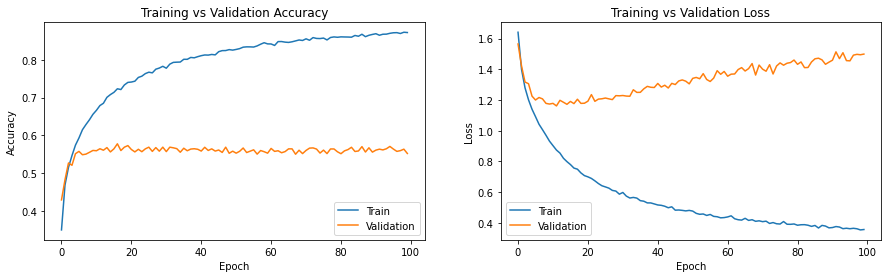

In [77]:
.

### MDL6: Base + Switching Pooling and Dropout Layers

In [78]:
# creating a sequential model
mdl6 = Sequential()
mdl6.add(
    Conv2D(
        128, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl6.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))
mdl6.add(Dropout(0.25))

mdl6.add(
    Conv2D(
        128, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl6.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))
mdl6.add(Dropout(0.25))

mdl6.add(
    Conv2D(
        256, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl6.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))
mdl6.add(Dropout(0.25))


mdl6.add(Flatten())
mdl6.add(Dense(7, activation='softmax'))

# compile the model
mdl6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

mdl6_performance = mdl6.fit(
    x=train_images,
    y=y_train, 
    validation_data = (validation_images, y_validation),
    epochs=100)

#compare how the model performs on the test dataset:
mdl6_test_loss, mdl6_test_acc = mdl6.evaluate(test_images, y_test, verbose=2)
print(f'\nTest accuracy: {mdl6_test_acc * 100.0:.2f}%')

# visualize accuracy
plot_model_accuracy(mdl6_performance)

Epoch 1/100
898/898 [==============================] - 55s 62ms/step - loss: 1.6790 - accuracy: 0.3273 - val_loss: 1.5224 - val_accuracy: 0.4221
Epoch 2/100
898/898 [==============================] - 55s 61ms/step - loss: 1.4353 - accuracy: 0.4530 - val_loss: 1.3365 - val_accuracy: 0.4976
Epoch 3/100
898/898 [==============================] - 55s 61ms/step - loss: 1.3166 - accuracy: 0.4986 - val_loss: 1.2825 - val_accuracy: 0.5113
Epoch 4/100
898/898 [==============================] - 55s 62ms/step - loss: 1.2420 - accuracy: 0.5304 - val_loss: 1.2264 - val_accuracy: 0.5389
Epoch 5/100
898/898 [==============================] - 57s 63ms/step - loss: 1.1838 - accuracy: 0.5535 - val_loss: 1.2045 - val_accuracy: 0.5411
Epoch 6/100
898/898 [==============================] - 57s 63ms/step - loss: 1.1395 - accuracy: 0.5678 - val_loss: 1.2022 - val_accuracy: 0.5581
Epoch 7/100
898/898 [==============================] - 55s 61ms/step - loss: 1.1026 - accuracy: 0.5886 - val_loss: 1.1775 - val_ac

KeyboardInterrupt: 

### MDL7: Base + Testing BatchNormalization Instead of Dropout for Regularization

Epoch 1/10
898/898 [==============================] - 57s 63ms/step - loss: 2.1850 - accuracy: 0.3652 - val_loss: 1.8520 - val_accuracy: 0.4218
Epoch 2/10
898/898 [==============================] - 55s 61ms/step - loss: 1.4946 - accuracy: 0.4916 - val_loss: 1.4979 - val_accuracy: 0.4611
Epoch 3/10
898/898 [==============================] - 55s 62ms/step - loss: 1.1661 - accuracy: 0.5750 - val_loss: 1.3636 - val_accuracy: 0.5085
Epoch 4/10
898/898 [==============================] - 54s 60ms/step - loss: 0.9925 - accuracy: 0.6350 - val_loss: 1.3027 - val_accuracy: 0.5380
Epoch 5/10
898/898 [==============================] - 55s 62ms/step - loss: 0.8256 - accuracy: 0.6977 - val_loss: 1.3283 - val_accuracy: 0.5442
Epoch 6/10
898/898 [==============================] - 56s 62ms/step - loss: 0.6522 - accuracy: 0.7678 - val_loss: 1.5078 - val_accuracy: 0.5138
Epoch 7/10
898/898 [==============================] - 56s 62ms/step - loss: 0.4721 - accuracy: 0.8349 - val_loss: 1.8544 - val_accuracy:

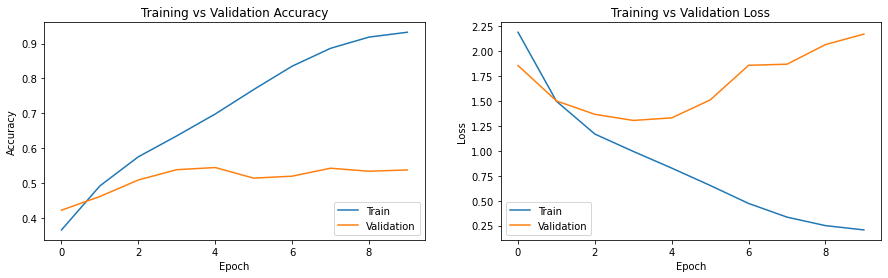

In [79]:
# creating a sequential model
mdl7 = Sequential()
mdl7.add(
    Conv2D(
        128, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl7.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))
mdl7.add(BatchNormalization())

mdl7.add(
    Conv2D(
        128, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl7.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))
mdl7.add(BatchNormalization())

mdl7.add(
    Conv2D(
        256, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl7.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))
mdl7.add(BatchNormalization())


mdl7.add(Flatten())
mdl7.add(Dense(7, activation='softmax'))

# compile the model
mdl7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

mdl7_performance = mdl7.fit(
    x=train_images,
    y=y_train, 
    validation_data = (validation_images, y_validation),
    epochs=10)

#compare how the model performs on the test dataset:
mdl7_test_loss, mdl7_test_acc = mdl7.evaluate(test_images, y_test, verbose=2)
print(f'\nTest accuracy: {mdl7_test_acc * 100.0:.2f}%')

# visualize accuracy
plot_model_accuracy(mdl7_performance)

### MDL8: Base + Swapping Pooling and BatchNormalization Layers

Epoch 1/10
898/898 [==============================] - 63s 70ms/step - loss: 2.4138 - accuracy: 0.3333 - val_loss: 2.1369 - val_accuracy: 0.3238
Epoch 2/10
898/898 [==============================] - 62s 69ms/step - loss: 1.6273 - accuracy: 0.4532 - val_loss: 1.5914 - val_accuracy: 0.4330
Epoch 3/10
898/898 [==============================] - 62s 69ms/step - loss: 1.3178 - accuracy: 0.5280 - val_loss: 1.4990 - val_accuracy: 0.4642
Epoch 4/10
898/898 [==============================] - 63s 70ms/step - loss: 1.1579 - accuracy: 0.5785 - val_loss: 1.4915 - val_accuracy: 0.4653
Epoch 5/10
898/898 [==============================] - 62s 69ms/step - loss: 1.0213 - accuracy: 0.6270 - val_loss: 1.4742 - val_accuracy: 0.4567
Epoch 6/10
898/898 [==============================] - 62s 70ms/step - loss: 0.8822 - accuracy: 0.6770 - val_loss: 1.4564 - val_accuracy: 0.5113
Epoch 7/10
898/898 [==============================] - 63s 70ms/step - loss: 0.7375 - accuracy: 0.7333 - val_loss: 1.4252 - val_accuracy:

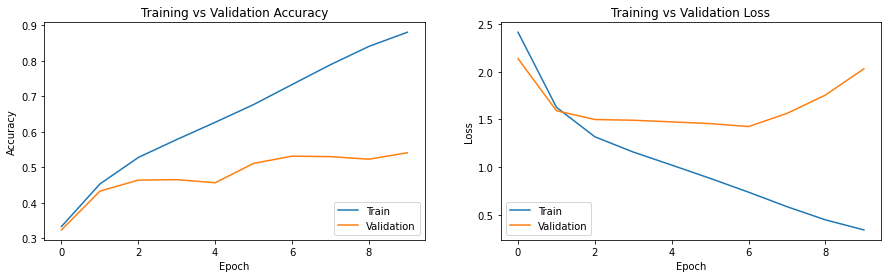

In [80]:
# creating a sequential model
mdl8 = Sequential()
mdl8.add(
    Conv2D(
        128, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl8.add(BatchNormalization())
mdl8.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))

mdl8.add(
    Conv2D(
        128, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl8.add(BatchNormalization())
mdl8.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))


mdl8.add(
    Conv2D(
        256, kernel_size = 3, 
        activation='relu', 
        input_shape = (48,48,1),
        padding='same'))
mdl8.add(BatchNormalization())
mdl8.add(MaxPool2D(
    pool_size=(2, 2),
    padding='same'))


mdl8.add(Flatten())
mdl8.add(Dense(7, activation='softmax'))

# compile the model
mdl8.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

mdl8_performance = mdl8.fit(
    x=train_images,
    y=y_train, 
    validation_data = (validation_images, y_validation),
    epochs=10)

#compare how the model performs on the test dataset:
mdl8_test_loss, mdl8_test_acc = mdl8.evaluate(test_images, y_test, verbose=2)
print(f'\nTest accuracy: {mdl8_test_acc * 100.0:.2f}%')

# visualize accuracy
plot_model_accuracy(mdl8_performance)

## Interpreting the model

In [91]:
acc = [(1,0),#mdl1_placeholder
       (2,mdl2_test_acc), 
       (3,mdl3_test_acc),
       (4,mdl4_test_acc),
       (5,mdl5_test_acc),
       (6,0), #mdl6_placeholder
       (7,mdl7_test_acc),
       (8,mdl8_test_acc)]

In [92]:
for i,acc in acc:
    print(i,acc)

1 0
2 0.5547506809234619
3 0.5502926111221313
4 0.5486208200454712
5 0.5555865168571472
6 0
7 0.5374756455421448
8 0.5483421683311462


In [ ]:
# mdl5 has optimal parameters